# Sentiment Analysis of New York Times Articles (2022)

This notebook performs sentiment analysis on New York Times article titles from 2022, analyzing sentiment trends throughout the year.

## Table of Contents
1. Data Collection
2. Data Storage
3. Sentiment Analysis
4. Visualization
5. Semantic Analysis

# Imports


In [2]:
import requests
import pandas as pd
import sqlite3
from datetime import datetime
import time
import os

from transformers import pipeline
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\zecab\Repositories\Sentiment_Analysis_NYT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load environment variables

In [3]:
# NYT API configuration
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv("API_KEY")

BASE_URL = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

In [13]:
def get_last_day(year, month):
    if month in [4, 6, 9, 11]:
        return 30
    elif month == 2:
        # Check for leap year
        if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):
            return 29
        return 28
    return 31


def get_db_connection(db='nyt_articles'):
    return sqlite3.connect(db, timeout=10)


def fetch_articles(year, month, pages=1):
    articles = []
    begin_date = f"{year}{month:02d}01"
    last_day = get_last_day(year, month)
    end_date = f"{year}{month:02d}{last_day}"

    for page in range(0, pages):  # Fetch articles (n pages * 10 articles)
        try:
            params = {
                "api-key": API_KEY,
                "begin_date": begin_date,
                "end_date": end_date,
                "fq": 'section.name:("U.S." "World")',
                "page": page
            }

            response = requests.get(BASE_URL, params=params, timeout=10)
            if response.status_code == 200:
                data = response.json()
                if "response" in data and "docs" in data["response"]:
                    articles.extend([doc["headline"]["main"] for doc in data["response"]["docs"]])
            else:
                print(f"Request failed with status code: {response.status_code}")

        except requests.exceptions.RequestException as e:
            print(f"Request error occurred: {e}")
            time.sleep(30)  # Wait longer on error
            continue

        time.sleep(6)  # Rate limiting
        print('sleeping.....')
    return articles


In [4]:
# Create SQLite database
with get_db_connection() as conn:
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS article_titles (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            title TEXT,
            year INTEGER,
            month INTEGER
        )
    ''')
    conn.commit()

In [ ]:
# Collect articles for each month of 2022

year = 2022
with get_db_connection() as conn:
    cursor = conn.cursor()
    for month in range(1, 13):
        articles = fetch_articles(year, month)
        for title in articles:
            cursor.execute(
                "INSERT INTO article_titles (title, year, month) VALUES (?, ?, ?)",
                (title, year, month)
            )
        print(f'month {month} done.')

        conn.commit()

sleeping.....
sleeping.....
sleeping.....
month 1 done.
sleeping.....
sleeping.....
Request failed with status code: 429
sleeping.....
month 2 done.
Request failed with status code: 429


In [14]:
# Load articles from database
with get_db_connection('titles.db') as conn:
    df = pd.read_sql_query(
        "SELECT * FROM article_titles",
        conn
    )

In [15]:
# Initialize sentiment analyzer
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

Device set to use cpu


In [16]:
# Perform sentiment analysis
def get_sentiment_score(text):
    result = sentiment_analyzer(text)
    return 1 if result[0]['label'] == 'POSITIVE' else 0

df['sentiment_score'] = df['title'].apply(get_sentiment_score)

In [18]:
# Calculate monthly averages
monthly_sentiment = df.groupby('month')['sentiment_score'].mean().reset_index()

In [20]:
monthly_sentiment

,month,sentiment_score
0,1,0.5
1,2,0.5
2,3,0.0
3,4,0.2
4,5,0.4
5,6,0.2
6,7,0.1
7,8,0.4
8,9,0.5
9,10,0.4


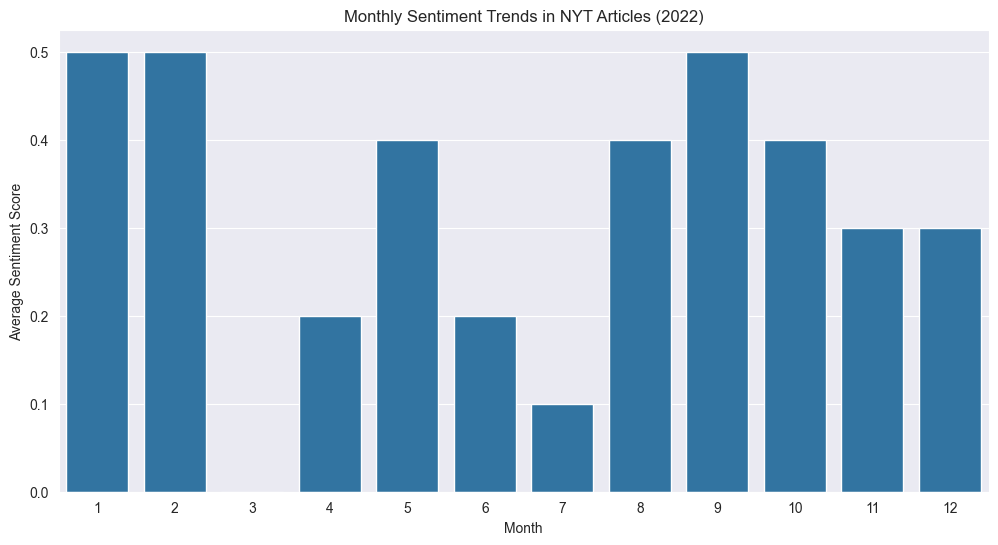

In [19]:
# Visualization 1: Monthly sentiment trends
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_sentiment, x='month', y='sentiment_score')
plt.title('Monthly Sentiment Trends in NYT Articles (2022)')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.show()

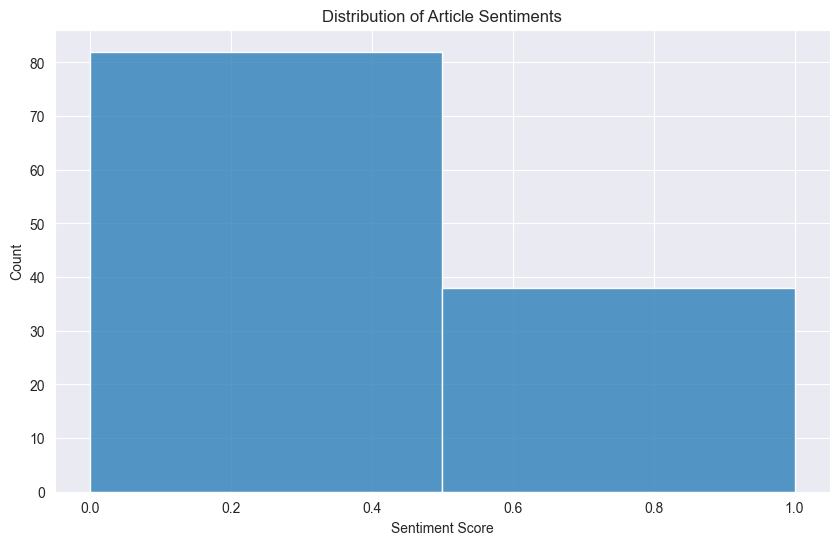

In [21]:
# Visualization 2: Sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='sentiment_score', bins=2)
plt.title('Distribution of Article Sentiments')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

In [22]:
# Initialize sentence transformer
model = SentenceTransformer('all-MiniLM-L6-v2')

C:\Users\zecab\Repositories\Sentiment_Analysis_NYT\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zecab\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not ins

In [24]:
sample_size = 100
# Reset the index after sampling to ensure continuous integer indexing
sample_titles = df['title'].sample(n=sample_size, random_state=42).reset_index(drop=True)
embeddings = model.encode(sample_titles)

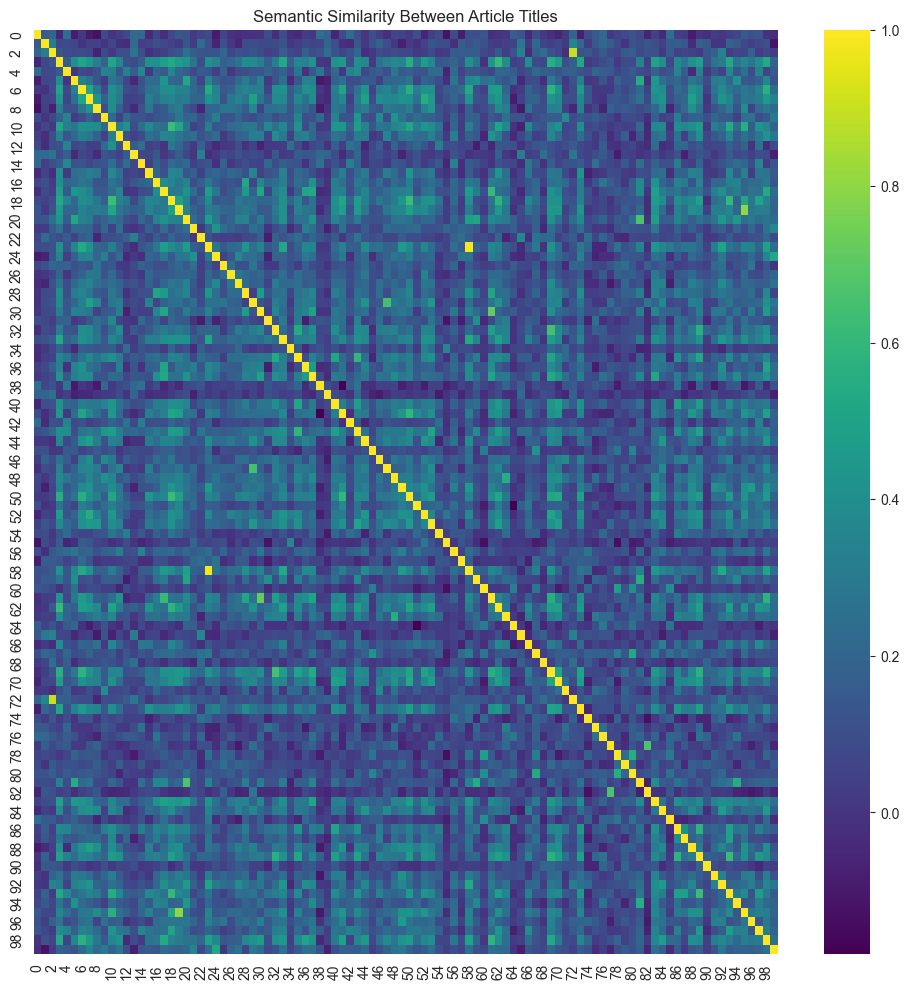

In [25]:
# Calculate similarity matrix
import numpy as np
similarity_matrix = np.inner(embeddings, embeddings)

# Plot similarity heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title('Semantic Similarity Between Article Titles')
plt.show()

In [26]:
# Close database connection
conn.close()

## Conclusion

This analysis reveals patterns in sentiment across NYT articles throughout 2022. The visualizations show:
1. Monthly trends in article sentiment
2. Overall distribution of positive vs negative articles
3. Semantic relationships between article titles

Note: To use this notebook, replace the `API_KEY` variable with your actual NYT API key.